# Clothing Classifier Model

## Project Case Study

Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

## Credits

Datacamp

![clothing_classification](./assets/images/clothing_classification.png)


# 1. Import Libraries

In [79]:
# Common Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit learn
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall
from torchvision import datasets
import torchvision.transforms as transforms

# 2. Data Loading

In [ ]:
train_data = datasets.FashionMNIST(root='./assets/datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./assets/datasets', train=False, download=True, transform=transforms.ToTensor())

In [12]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./assets/datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./assets/datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [27]:
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

test_images = test_data.data.numpy()
test_labels = test_data.targets.numpy()

In [33]:
print(f"Shape of train images: {train_images.shape}")
print(f"Shape of train labels: {train_labels.shape}")
print(f"Shape of test images: {test_images.shape}")
print(f"Shape of test labels: {test_labels.shape}")

Shape of train images: (60000, 28, 28)
Shape of train labels: (60000,)
Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)


* The (28x28) corresponds to grayscale images

In [24]:
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [34]:
print(f"Shape of flattened train images: {train_images_flat.shape}")
print(f"Shape of flatenned test images: {test_images_flat.shape}")

Shape of flattened train images: (60000, 784)
Shape of flatenned test images: (10000, 784)


* 784 represents the total number of pixels in one channel of a 28x28 image.
    * The FashionMNIST images are grayscale, meaning they have only one channel.
    * Each image is 28 pixels in height and 28 pixels in width.
    * The total number of pixels in one channel is 28x28=784.
    * When you flatten the image into a vector, you get a 1D array of length 784, representing all pixel intensity values of that single channel.

* So, 784 corresponds to the pixel count of the single grayscale channel for each image.

* Flatten each image into a 1D vector from its original 2D shape:
    * Many classical machine learning models or fully connected neural networks expect input features as 1-dimensional vectors rather than 2D matrices.
    * Flattening converts each 2D image (e.g., 28x28 pixels) into a single vector of length 784 (28*28), suitable for feeding into such models.
    * In contrast, CNNs usually require the images to remain in 2D (with channel info) to exploit spatial structure, so this step is often done only when using non-CNN models or certain preprocessing.
    * This reshaping preserves all pixel data but changes the shape for compatibility with models that do not handle multi-dimensional spatial input

In [36]:
df_train = pd.DataFrame(train_images_flat)
df_train['label'] = train_labels

df_test = pd.DataFrame(test_images_flat)
df_test['label'] = test_labels

In [37]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,3,0,3,174,189,67,0,0,0,2
2,0,0,0,0,0,0,0,0,1,0,...,58,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,2,0,1,1,0,0,0,...,12,0,0,0,0,0,0,0,0,6


In [39]:
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (60000, 785)
Shape of df_test: (10000, 785)


# 3. EDA

## 3.1 Understand Target variable

In [6]:
# Get the number of classes
classes = train_data.classes
num_classes = len(classes)

print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of classes: 10


In [41]:
df_train["label"].value_counts().index

Index([9, 0, 3, 2, 7, 5, 1, 6, 4, 8], dtype='int64', name='label')

In [46]:
mapping = {i: class_name for i, class_name in enumerate(train_data.classes)}
print(mapping)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


* This is a simple mapping function to identify the output layer outputs

## 3.2 Display Images

In [93]:
def show_images(classes, images, labels, num_images=25):
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.title(classes[labels[i]])
    plt.show()

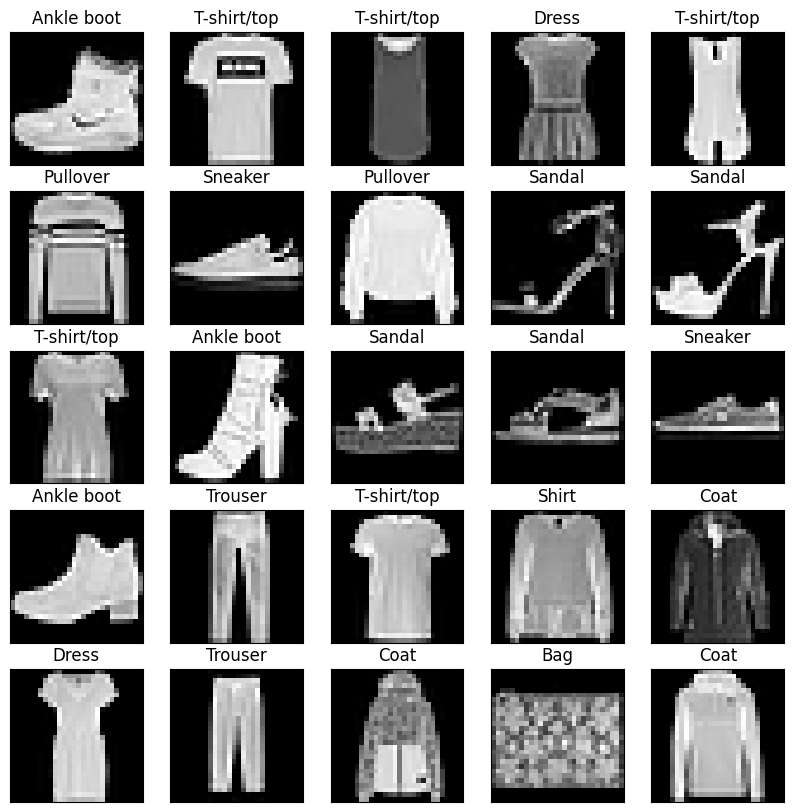

In [94]:
show_images(classes, train_images, train_labels)

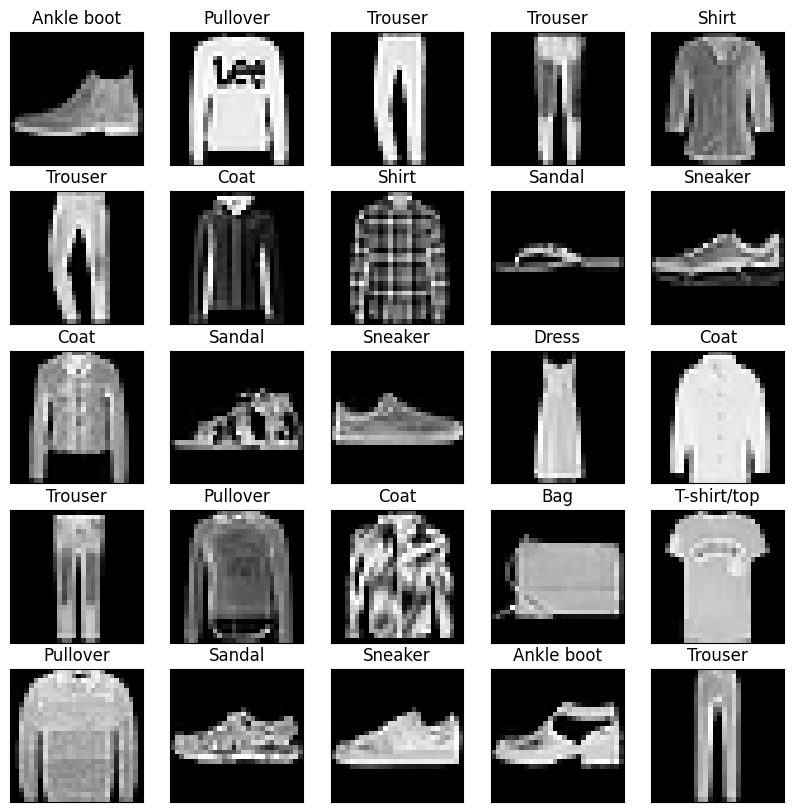

In [95]:
show_images(classes, test_images, test_labels)

# 4. CNN

## 4.1 CNN Functions

### 4.1.1 Designing the multi image classifier

In [ ]:
class MultiClassImageClassifier(nn.Module):

    def __init__(self, num_input_channels, num_output_channels, num_classes, image_size):
        super(MultiClassImageClassifier, self).__init__()

        # Single Convolution Layer
        self.conv1 = nn.Conv2d(
            num_input_channels, # 1
            num_output_channels, # 16
            kernel_size=3, # standard small filter size
            stride=1,
            padding=1
        )

        # ReLU Activation Layer
        self.relu = nn.ReLU()

        # Max Pooling Layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # reduces spatial dimensionality by half
        
        # Flattening: Maps to the number_classes
        self.flatten = nn.Flatten()

        # FCN: Fully Connected Layer
        self.fc = nn.Linear(num_output_channels * (image_size//2)**2, num_classes) # input: 16 * ((image_size//2) * (image_size//2)), output: num_classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

### Idea

| Layer                 | Input Size         | Output Size        | Number of Parameters (Weights + Bias)                                        |
| --------------------- | ------------------ | ------------------ | ---------------------------------------------------------------------------- |
| Conv1                 | 1 channel, 28x28   | 16 channels, 28x28 | (1×3×3)×16+16=160(1x3x3)x16 + 16 = 160(1×3×3)×16+16=160 |
| ReLU                  | 16 channels, 28x28 | 16 channels, 28x28 | 0                                                                            |
| MaxPooling            | 16 channels, 28x28 | 16 channels, 14x14 | 0                                                                            |
| Flatten               | 16 channels, 14x14 | 16x14x14 = 3136 (vector)      | 0                                                                            |
| Fully Connected (fc1) | 3136 (vector)      | 10 (classes)       | 3136×10+10=31370 |

* Input images are grayscale with shape 28x28 pixels, represented as 1 input channel.
* Convolutional layer uses 16 filters of size 3x3 with padding 1, keeping spatial dimensions the same.
* MaxPooling reduces spatial dimensions by half (28x28 → 14x14).
* Flatten reshapes the pooled features into a vector for the fully connected layer.
* Fully connected layer maps the 3136 input features to 10 output classes (clothing categories).

### 4.1.2 Training Model Function

In [56]:
# Define training function
def train_model(dataloader_train, optimizer, net, num_epochs):
    num_processed = 0
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0
        for features, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)
        print(f'epoch {epoch}, loss: {running_loss / num_processed}')
        
    train_loss = running_loss / len(dataloader_train)
    return train_loss

## 4.2 Define Parameters

In [74]:
# DataLoaders
dataloader_train = DataLoader(train_data, batch_size=10, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
# Parameters
num_classes = len(classes)
num_input_channels = 1 # grayscale images for FashionMNIST data
num_output_channels = 16 # balances between model capacity and computational cost
image_size = train_data[0][0].shape[1] # 28
learning_rate = 0.001

## 4.3 Train the CNN model

In [60]:
cnn_model = MultiClassImageClassifier(num_input_channels, num_output_channels, num_classes, image_size)

In [69]:
for name, param in cnn_model.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}")

Name: conv1.weight, Shape: torch.Size([16, 1, 3, 3])
Name: conv1.bias, Shape: torch.Size([16])
Name: fc.weight, Shape: torch.Size([10, 3136])
Name: fc.bias, Shape: torch.Size([10])


In [71]:
adam_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [73]:
# Train for 1 epoch
train_model(dataloader_train, optimizer=adam_optimizer, net=cnn_model, num_epochs=1)

epoch 0, loss: 0.03990847553059769


0.3990847553059769

## 4.4 Test the CNN model

### 4.4.1 Define Metrics

In [ ]:
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=num_classes, average=None)

### 4.4.2 Run the CNN model on test set

In [83]:
cnn_model.eval()
predictions = []
true_labels = []

for i, (features, labels) in enumerate(dataloader_test):
    output = cnn_model(features.reshape(-1, 1, image_size, image_size))
    cat = torch.argmax(output, dim=-1)
    predictions.extend(cat.tolist())
    true_labels.extend(labels.tolist())
    
    accuracy_metric(cat, labels)
    precision_metric(cat, labels)
    recall_metric(cat, labels)

In [85]:
predictions[:10]

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]

In [86]:
true_labels[:10]

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]

### 4.4.3 Compute the metrics

In [87]:
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
print(f'Accuracy: {accuracy}')
print(f'Precision (per class): {precision}')
print(f'Recall (per class): {recall}')

Accuracy: 0.8841000199317932
Precision (per class): [0.826129674911499, 0.9712015986442566, 0.7933271527290344, 0.9142550826072693, 0.8525139689445496, 0.9778671860694885, 0.6558935642242432, 0.9286394119262695, 0.9623762369155884, 0.9781477451324463]
Recall (per class): [0.8410000205039978, 0.9779999852180481, 0.8560000061988831, 0.8529999852180481, 0.7630000114440918, 0.972000002861023, 0.6899999976158142, 0.9760000109672546, 0.972000002861023, 0.9399999976158142]


In [90]:
cm = confusion_matrix(true_labels, predictions)
cm

array([[841,   0,  16,  12,   3,   2, 117,   0,   9,   0],
       [  2, 978,   0,  10,   3,   0,   5,   0,   2,   0],
       [ 12,   1, 856,   7,  46,   1,  74,   0,   3,   0],
       [ 34,  21,  15, 853,  16,   0,  56,   0,   5,   0],
       [  1,   1, 106,  30, 763,   0,  96,   0,   3,   0],
       [  0,   0,   0,   1,   0, 972,   0,  19,   1,   7],
       [126,   4,  86,  18,  63,   1, 690,   0,  12,   0],
       [  0,   0,   0,   0,   0,   9,   0, 976,   1,  14],
       [  2,   2,   0,   2,   1,   2,  14,   5, 972,   0],
       [  0,   0,   0,   0,   0,   7,   0,  51,   2, 940]])

## 4.5 Data Viz

### 4.5.1 Confusion Matrix

In [91]:
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

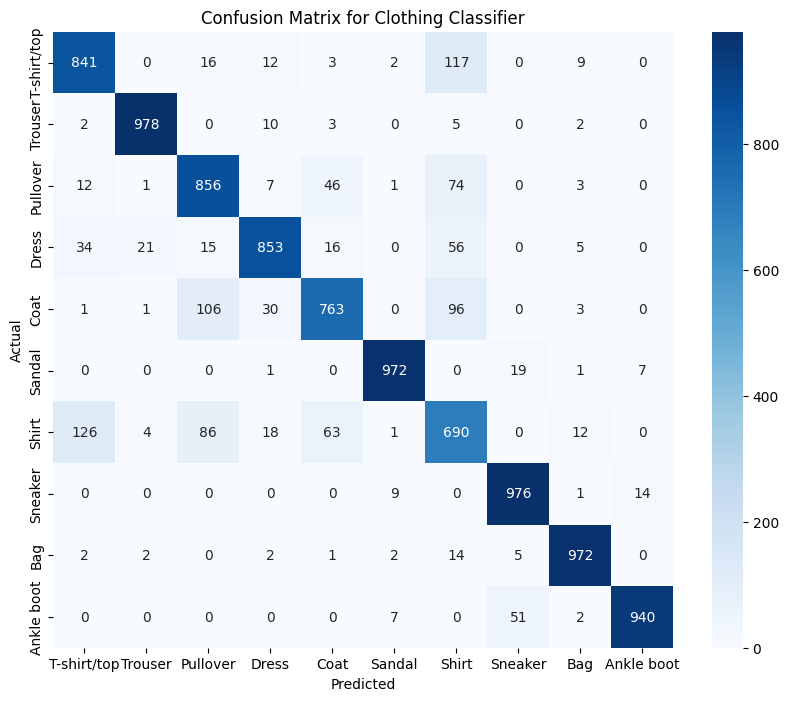

In [89]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Clothing Classifier')
plt.show()

### 4.5.2 Misclassified Samples Gallery

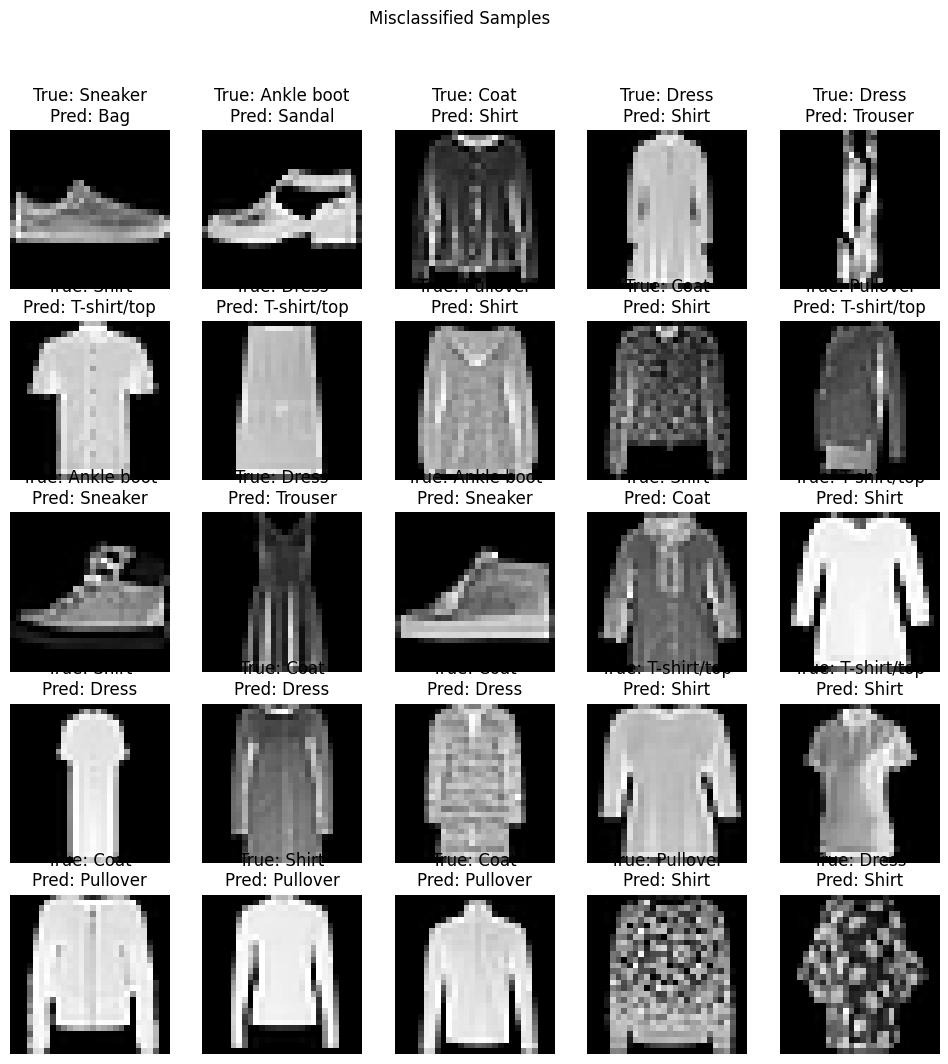

In [92]:
misclassified_indices = [i for i, (t, p) in enumerate(zip(true_labels, predictions)) if t != p]

plt.figure(figsize=(12, 12))
num_display = min(25, len(misclassified_indices))  # display up to 25 samples

for i in range(num_display):
    idx = misclassified_indices[i]
    image = test_images[idx].squeeze()  # remove channel dim if needed
    true_label = classes[true_labels[idx]]
    pred_label = classes[predictions[idx]]

    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')

plt.suptitle('Misclassified Samples')
plt.show()